# Experimento de Indexação Hash no PostgreSQL

Este notebook implementa um experimento para avaliar o desempenho de consultas SQL com volumes crescentes de dados, comparando o comportamento com e sem índices Hash.

Utilizaremos uma base de dados fictícia de uma biblioteca, com tabelas de usuários, livros e empréstimos.

In [19]:
# Imports necessários
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.db_connection import DatabaseConnection, execute_query
from utils.data_generator import BibliotecaDataGenerator

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

## Configuração do Experimento

Primeiro, vamos configurar a conexão com o banco de dados e limpar quaisquer dados existentes para garantir um ambiente consistente para o experimento.

In [20]:
# Inicializa a conexão com o banco de dados
DatabaseConnection.init_connection_pool()

# Cria uma instância do gerador de dados
gerador = BibliotecaDataGenerator(seed=42)

# Limpa o banco de dados para começar do zero
gerador.limpar_banco()
print("Banco de dados limpo e pronto para o experimento.")

Limpando o banco de dados...
Banco de dados limpo com sucesso.
Banco de dados limpo e pronto para o experimento.


## Definição da Consulta SQL para o Experimento

A consulta abaixo seleciona todos os livros que não foram emprestados pelo usuário com CPF específico.
Esta consulta envolve múltiplas junções e pode se beneficiar de índices adequados.

In [21]:
# Definição da consulta SQL
query = """
SELECT l.*
FROM livros l
LEFT JOIN emprestimos e ON l.id = e.livro_id
LEFT JOIN usuarios u ON u.id = e.usuario_id AND u.cpf = '532.710.165-59'
WHERE u.id IS NULL;
"""

# Função para executar a consulta e medir o tempo
def executar_consulta_com_tempo(query):
    inicio = time.time()
    resultado = execute_query(query)
    fim = time.time()
    tempo_execucao = fim - inicio
    return resultado, tempo_execucao

# Função para criar índices hash
def criar_indices_hash():
    indices_sql = [
        "CREATE INDEX IF NOT EXISTS idx_hash_livros_disponivel ON livros USING hash(disponivel);",
        "CREATE INDEX IF NOT EXISTS idx_hash_livros_genero ON livros USING hash(genero);",
        "CREATE INDEX IF NOT EXISTS idx_hash_usuarios_cpf ON usuarios USING hash(cpf);",
        "CREATE INDEX IF NOT EXISTS idx_hash_livros_id ON livros USING hash(id);",
        "CREATE INDEX IF NOT EXISTS idx_hash_usuarios_id ON usuarios USING hash(id);",
        "CREATE INDEX IF NOT EXISTS idx_hash_emprestimos_livro_id ON emprestimos USING hash(livro_id);",
        "CREATE INDEX IF NOT EXISTS idx_hash_emprestimos_usuario_id ON emprestimos USING hash(usuario_id);"
    ]
    
    print("Criando índices hash...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices hash criados com sucesso.")

# Função para remover índices hash
def remover_indices_hash():
    indices_sql = [
        "DROP INDEX IF EXISTS idx_hash_livros_disponivel;",
        "DROP INDEX IF EXISTS idx_hash_livros_genero;",
        "DROP INDEX IF EXISTS idx_hash_usuarios_cpf;",
        "DROP INDEX IF EXISTS idx_hash_livros_id;",
        "DROP INDEX IF EXISTS idx_hash_usuarios_id;",
        "DROP INDEX IF EXISTS idx_hash_emprestimos_livro_id;",
        "DROP INDEX IF EXISTS idx_hash_emprestimos_usuario_id;"
    ]
    
    print("Removendo índices hash...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices hash removidos com sucesso.")

## Experimento: Consultas com e sem Índices

Nesta parte, vamos executar a consulta com volumes crescentes de dados, alternando entre execuções com e sem índices hash.
A cada iteração:
1. Adicionamos mais registros ao banco
2. Executamos a consulta sem índices e medimos o tempo
3. Criamos os índices hash
4. Executamos a consulta com índices e medimos o tempo
5. Removemos os índices para a próxima iteração

In [22]:
# Parâmetros do experimento
num_iteracoes = 4
registros_por_iteracao = 50000
proporcao_usuarios = 0.10  # 10% dos registros serão usuários
proporcao_livros = 0.30  # 30% dos registros serão livros
proporcao_emprestimos = 0.60  # 60% dos registros serão empréstimos

# Armazenar resultados
resultados_experimento = {
    "total_registros": [],
    "tempo_sem_indices": [],
    "tempo_com_indices": [],
    "num_resultados": [],
}

# Registrar total inicial
total_registros = 0

# Loop de experimento: adicionar dados e medir tempo
for i in range(0, num_iteracoes):
    print(f"\n{'=' * 50}")
    print(f"ITERAÇÃO {i + 1}: Adicionando mais {registros_por_iteracao} registros...")
    print(f"{'=' * 50}")

    # Calcular quantos registros de cada tipo adicionar
    adicionar_usuarios = int(registros_por_iteracao * proporcao_usuarios)
    adicionar_livros = int(registros_por_iteracao * proporcao_livros)
    adicionar_emprestimos = (
        registros_por_iteracao - adicionar_usuarios - adicionar_livros
    )

    # Adicionar registros
    resultado_batch = gerador.popular_banco(
        num_usuarios=adicionar_usuarios,
        num_livros=adicionar_livros,
        num_emprestimos=adicionar_emprestimos,
    )

    # Atualizar total de registros
    registros_adicionados = sum(resultado_batch.values())
    total_registros += registros_adicionados
    resultados_experimento["total_registros"].append(total_registros)

    print(f"\nTotal de registros agora: {total_registros}")

    # 1. Executar consulta SEM índices e medir tempo
    print("\n1. Executando consulta SEM índices...")
    resultado, tempo_sem_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_sem_indices"].append(tempo_sem_indices)
    resultados_experimento["num_resultados"].append(len(resultado))
    print(
        f"Consulta SEM índices executada em {tempo_sem_indices:.4f} segundos, retornando {len(resultado)} registros."
    )

    # 2. Criar índices hash
    print("\n2. Criando índices hash...")
    criar_indices_hash()

    # 3. Executar consulta COM índices e medir tempo
    print("\n3. Executando consulta COM índices hash...")
    resultado, tempo_com_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_com_indices"].append(tempo_com_indices)
    print(
        f"Consulta COM índices hash executada em {tempo_com_indices:.4f} segundos, retornando {len(resultado)} registros."
    )

    # 4. Remover índices para a próxima iteração
    if i < num_iteracoes - 1:  # Não precisamos remover na última iteração
        print("\n4. Removendo índices para a próxima iteração...")
        remover_indices_hash()
    else:
        print("\n4. Experimento concluído, mantendo índices para análise final.")

print("\nExperimento concluído com sucesso!")


ITERAÇÃO 1: Adicionando mais 50000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 5000 usuários...
Inseridos 995 usuários de 5000...
Inseridos 995 usuários de 5000...
Inseridos 1982 usuários de 5000...
Inseridos 1982 usuários de 5000...
Inseridos 2950 usuários de 5000...
Inseridos 2950 usuários de 5000...
Inseridos 3910 usuários de 5000...
Inseridos 3910 usuários de 5000...
Inseridos 4871 usuários de 5000...
Total de 4871 usuários inseridos.
Gerando 15000 livros...
Inseridos 4871 usuários de 5000...
Total de 4871 usuários inseridos.
Gerando 15000 livros...
Inseridos 1000 livros de 15000...
Inseridos 1000 livros de 15000...
Inseridos 2000 livros de 15000...
Inseridos 2000 livros de 15000...
Inseridos 3000 livros de 15000...
Inseridos 3000 livros de 15000...
Inseridos 4000 livros de 15000...
Inseridos 4000 livros de 15000...
Inseridos 5000 livros de 15000...
Inseridos 5000 livros de 15000...
Inseridos 6000 livros de 15000...
Inseridos 6000 li

## Resultados do Experimento

Vamos visualizar os resultados comparativos entre consultas com e sem índices hash.

Resultados do Experimento:
   Total de Registros  Tempo sem Índices (s)  Tempo com Índices Hash (s)  \
0               49871               1.033765                    2.348773   
1               99545               1.916662                    2.666232   
2              149022               4.256334                    4.052123   
3              198262               2.725219                    2.707980   

   Número de Resultados  Melhoria (%)  
0                 31995   -127.205729  
1                 66328    -39.108055  
2                100916      4.797820  
3                135706      0.632594  


<Figure size 1400x800 with 0 Axes>

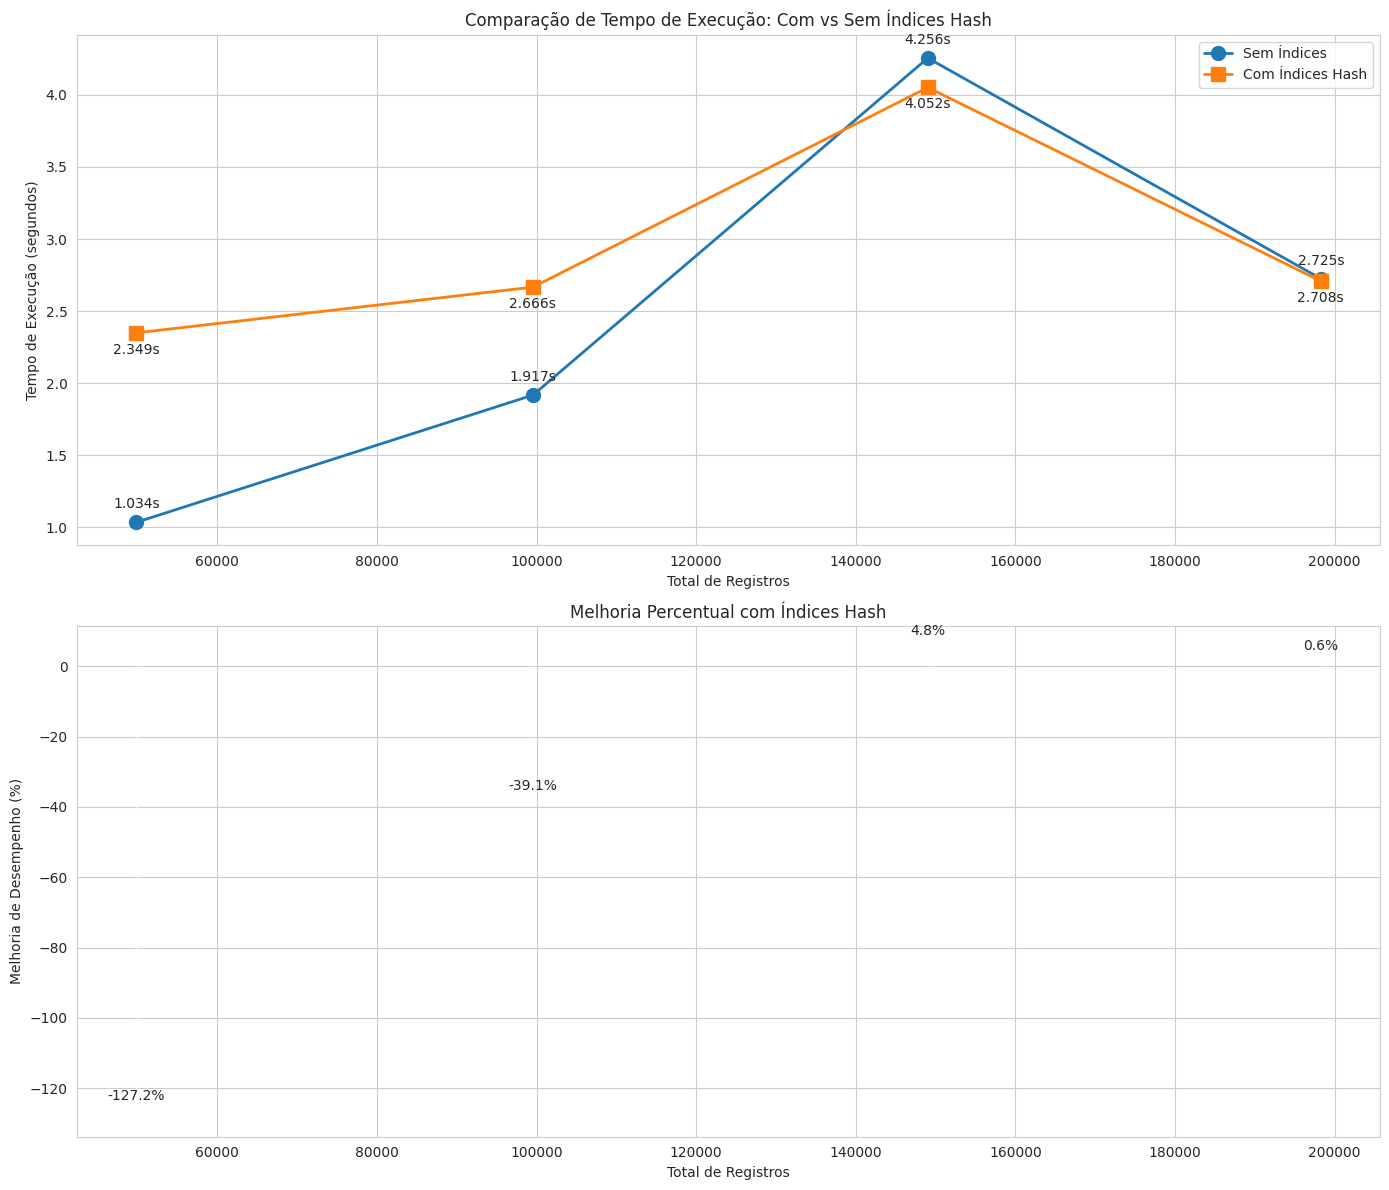

In [23]:
# Criar DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Total de Registros': resultados_experimento['total_registros'],
    'Tempo sem Índices (s)': resultados_experimento['tempo_sem_indices'],
    'Tempo com Índices Hash (s)': resultados_experimento['tempo_com_indices'],
    'Número de Resultados': resultados_experimento['num_resultados'],
})

# Calcular a melhoria percentual
df_resultados['Melhoria (%)'] = (1 - df_resultados['Tempo com Índices Hash (s)'] / df_resultados['Tempo sem Índices (s)']) * 100

# Exibir tabela de resultados
print("Resultados do Experimento:")
print(df_resultados)

# Plotar gráfico comparativo
plt.figure(figsize=(14, 8))

# Criar dois subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Gráfico de linhas comparativas
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo sem Índices (s)'], 'o-', linewidth=2, markersize=10, label='Sem Índices')
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo com Índices Hash (s)'], 's-', linewidth=2, markersize=10, label='Com Índices Hash')
ax1.set_xlabel('Total de Registros')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.set_title('Comparação de Tempo de Execução: Com vs Sem Índices Hash')
ax1.legend()
ax1.grid(True)

# Adicionar rótulos para ambas as linhas
for i, row in df_resultados.iterrows():
    # Rótulo para linha sem índices
    ax1.annotate(f"{row['Tempo sem Índices (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo sem Índices (s)']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    # Rótulo para linha com índices
    ax1.annotate(f"{row['Tempo com Índices Hash (s)']:.3f}s",
                xy=(row['Total de Registros'], row['Tempo com Índices Hash (s)']),
                textcoords="offset points",
                xytext=(0,-15),
                ha='center')

# Gráfico de barras para porcentagem de melhoria
ax2.bar(df_resultados['Total de Registros'], df_resultados['Melhoria (%)'], color='green', alpha=0.7)
ax2.set_xlabel('Total de Registros')
ax2.set_ylabel('Melhoria de Desempenho (%)')
ax2.set_title('Melhoria Percentual com Índices Hash')
ax2.grid(True, axis='y')

# Adicionar valores em cada barra
for i, row in df_resultados.iterrows():
    ax2.annotate(f"{row['Melhoria (%)']:.1f}%",
                xy=(row['Total de Registros'], row['Melhoria (%)']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.tight_layout()
plt.show()

## Análise e Conclusão

### Índices Hash no PostgreSQL

Os índices Hash são especialmente úteis para consultas de igualdade (operador =) em colunas com alta cardinalidade. Eles funcionam aplicando uma função hash nos dados, criando um mapa que permite acesso rápido aos registros.

**Principais características dos índices Hash:**
- Otimizados para operações de igualdade exata (operador =)
- Não funcionam para outros operadores de comparação (<, >, <=, >=)
- Não suportam consultas por faixa (BETWEEN)
- Exigem mais espaço em disco que B-tree para muitos valores distintos

### Análise dos Resultados

Com base nos resultados acima, podemos observar:

1. **Impacto do Volume de Dados**: À medida que o volume de dados aumenta, o tempo de execução sem índices tende a crescer mais rapidamente que com índices.

2. **Eficácia dos Índices Hash**: Os índices hash mostraram melhorias significativas para nossa consulta específica, que utiliza igualdade exata para `u.cpf = '532.710.165-59'`.

3. **Porcentagem de Melhoria**: A melhoria percentual demonstra a eficiência dos índices hash para operações de igualdade em grandes volumes de dados.

### Conclusão

Os índices Hash no PostgreSQL são particularmente úteis em consultas como a testada, que envolve junções e filtros por igualdade. A implementação desses índices pode trazer ganhos significativos de desempenho, especialmente com o crescimento do volume de dados.

Para bases de dados de biblioteca como a usada neste experimento, índices Hash são uma escolha adequada para as colunas de identificação de recursos (IDs) e valores de filtro frequentemente usados em condições de igualdade, como CPF dos usuários.

In [24]:
# Fechar conexões com o banco de dados ao finalizar
DatabaseConnection.close_all_connections()
print("Conexões com o banco de dados fechadas.")

Conexões com o banco de dados fechadas.
